In [1]:
import numpy as np
import json
import os
import seaborn as sns
import pandas as pd
from graphviz import Graph
import uuid
import tensorflow as tf

In [2]:
os.getcwd()

'/home/patryk/covid'

In [3]:
raw_train_ds = pd.read_json('./train.json', lines=True)
raw_test_ds = pd.read_json('./test.json', lines=True)

In [4]:
train_example = raw_train_ds.iloc[0,:]
print(train_example)

print()

test_example = raw_test_ds.iloc[0,:]
print(test_example)

index                                                                  0
id                                                          id_001f94081
sequence               GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...
structure              .....((((((.......)))).)).((.....((..((((((......
predicted_loop_type    EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...
signal_to_noise                                                    6.894
SN_filter                                                              1
seq_length                                                           107
seq_scored                                                            68
reactivity_error       [0.1359, 0.20700000000000002, 0.1633, 0.1452, ...
deg_error_Mg_pH10      [0.26130000000000003, 0.38420000000000004, 0.1...
deg_error_pH10         [0.2631, 0.28600000000000003, 0.0964, 0.1574, ...
deg_error_Mg_50C       [0.1501, 0.275, 0.0947, 0.18660000000000002, 0...
deg_error_50C          [0.2167, 0.34750000000000003

In [5]:
print(f"sequence: {len(train_example['sequence'])}")
print(f"structure: {len(train_example['structure'])}")
print(f"predicted_loop_type: {len(train_example['predicted_loop_type'])}")

print()

print(f"reactivity_error: {len(train_example['reactivity_error'])}")
print(f"deg_error_Mg_pH10: {len(train_example['deg_error_Mg_pH10'])}")
print(f"deg_error_pH10: {len(train_example['deg_error_pH10'])}")
print(f"deg_error_Mg_50C: {len(train_example['deg_error_Mg_50C'])}")
print(f"deg_error_50C: {len(train_example['deg_error_50C'])}")

print()

print(f"reactivity: {len(train_example['reactivity'])}")
print(f"deg_Mg_pH10: {len(train_example['deg_Mg_pH10'])}")
print(f"deg_pH10: {len(train_example['deg_pH10'])}")
print(f"deg_Mg_50C: {len(train_example['deg_Mg_50C'])}")
print(f"deg_50C: {len(train_example['deg_50C'])}")

sequence: 107
structure: 107
predicted_loop_type: 107

reactivity_error: 68
deg_error_Mg_pH10: 68
deg_error_pH10: 68
deg_error_Mg_50C: 68
deg_error_50C: 68

reactivity: 68
deg_Mg_pH10: 68
deg_pH10: 68
deg_Mg_50C: 68
deg_50C: 68


In [6]:
def prepare_labels(example):
    labels = ['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
    lists_to_stack = []
    for label in labels:
        lists_to_stack.append(example[label])
    return tf.transpose(tf.stack(lists_to_stack))

In [7]:
prepare_labels(train_example)

<tf.Tensor: shape=(68, 10), dtype=float32, numpy=
array([[0.1359, 0.2613, 0.2631, 0.1501, 0.2167, 0.3297, 0.7556, 2.3375,
        0.3581, 0.6382],
       [0.207 , 0.3842, 0.286 , 0.275 , 0.3475, 1.5693, 2.983 , 3.506 ,
        2.9683, 3.4773],
       [0.1633, 0.1372, 0.0964, 0.0947, 0.188 , 1.1227, 0.2526, 0.3008,
        0.2589, 0.9988],
       [0.1452, 0.2531, 0.1574, 0.1866, 0.2124, 0.8686, 1.3789, 1.0108,
        1.4552, 1.3228],
       [0.1314, 0.1798, 0.1   , 0.1369, 0.1703, 0.7217, 0.6376, 0.2635,
        0.7244, 0.7877],
       [0.105 , 0.1371, 0.1019, 0.1148, 0.1481, 0.4384, 0.3313, 0.3403,
        0.4971, 0.589 ],
       [0.0821, 0.1736, 0.114 , 0.0995, 0.1352, 0.256 , 0.6763, 0.5617,
        0.3819, 0.5231],
       [0.0964, 0.1791, 0.1341, 0.1449, 0.1834, 0.3364, 0.7525, 0.681 ,
        0.9115, 1.0125],
       [0.0756, 0.1056, 0.0517, 0.0705, 0.0638, 0.2168, 0.208 , 0.053 ,
        0.1668, 0.0585],
       [0.1087, 0.1896, 0.1474, 0.1588, 0.1804, 0.3583, 0.8908, 0.5348,
     

In [8]:
def encode_sequence(sequence):
    sequence_mapping = {'A': [1,0,0,0],
                        'C': [0,1,0,0],
                        'G': [0,0,1,0],
                        'U': [0,0,0,1]}
    encoded_sequence = []
    for char in sequence:
        encoded_sequence.append(sequence_mapping[char])
    return tf.constant(encoded_sequence, dtype=tf.float32)

In [9]:
encode_sequence(train_example['sequence'])

<tf.Tensor: shape=(107, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],


In [10]:
def encode_structure(structure):
    structure_mapping = {'.': [1,0,0],
                         '(': [0,1,0],
                         ')': [0,0,1]}
    encoded_structure = []
    for char in structure:
        encoded_structure.append(structure_mapping[char])
    return tf.constant(encoded_structure, dtype=tf.float32)

In [11]:
encode_structure(train_example['structure'])

<tf.Tensor: shape=(107, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
     

In [12]:
def encode_predicted_loop_type(predicted_loop_type):
    predicted_loop_type_mapping = {'S': [1,0,0,0,0,0,0],
                                   'M': [0,1,0,0,0,0,0],
                                   'I': [0,0,1,0,0,0,0],
                                   'B': [0,0,0,1,0,0,0],
                                   'H': [0,0,0,0,1,0,0],
                                   'E': [0,0,0,0,0,1,0],
                                   'X': [0,0,0,0,0,0,1]}
    encoded_predicted_loop_type = []
    for char in predicted_loop_type:
        encoded_predicted_loop_type.append(predicted_loop_type_mapping[char])
    return tf.constant(encoded_predicted_loop_type, dtype=tf.float32)

In [13]:
encode_predicted_loop_type(train_example['predicted_loop_type'])

<tf.Tensor: shape=(107, 7), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0

In [14]:
def prepare_features(example):
    encoded_sequence = encode_sequence(example['sequence'])
    encoded_structure = encode_structure(example['structure'])
    encoded_predicted_loop_type = encode_predicted_loop_type(example['predicted_loop_type'])
    return tf.concat([encoded_sequence, encoded_structure, encoded_predicted_loop_type], axis=1)

In [15]:
prepare_features(train_example)

<tf.Tensor: shape=(107, 14), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]], dtype=float32)>

# Raw example visualization

In [16]:
def retrive_connections(structure):
    open_indices = []
    connections = []
    for i, element in enumerate(structure):
        if element == '.':
            continue
        elif element == '(':
            open_indices.append(i)
        elif element == ')':
            connections.append((open_indices.pop(),i))
        else:
            raise "Incorrect structure"
    return connections

In [17]:
def create_graph(example):
    color_mapping = {'A': 'red', 'G': 'green', 'C': 'blue', 'U': 'yellow'}
    structure = example['structure']
    sequence = example['sequence']
    predicted_loop_type = example['predicted_loop_type']

    graph = Graph(engine='neato')
    graph.attr(rankdir="LR", size='20', overlap='false', sep='1', maxiter='99999999')
    
    graph.node(str(0), f"{sequence[0]}", style='filled', fillcolor=color_mapping[sequence[0]])
    for i in range(1, len(structure)):
        graph.node(str(i), f"{sequence[i]}", style='filled', fillcolor=color_mapping[sequence[i]])
        graph.edge(str(i-1), str(i))
    
    additional_connections = retrive_connections(structure)
    for x, y in additional_connections:
        graph.edge(str(x), str(y))
    return graph   

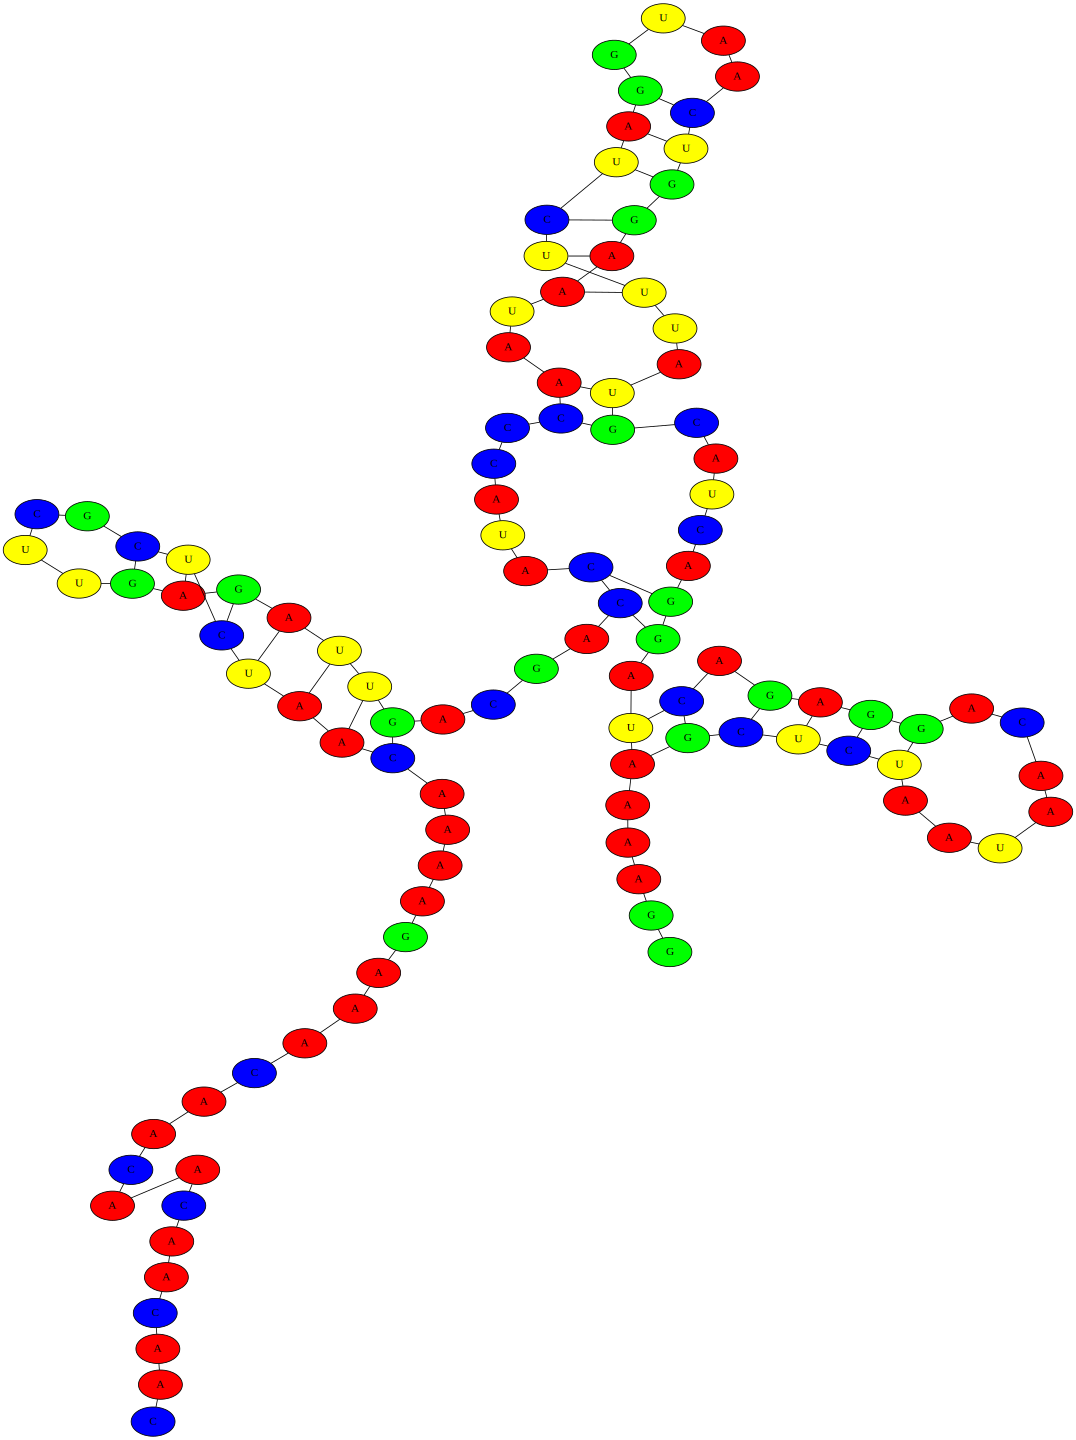

In [18]:
create_graph(train_example)

In [20]:
features = []
labels = []
for i in range(raw_train_ds.shape[0]):
    features.append(prepare_features(raw_train_ds.iloc[i,:]))
    labels.append(prepare_labels(raw_train_ds.iloc[i,:]))

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))

In [24]:
next(iter(dataset))

(<tf.Tensor: shape=(107, 14), dtype=float32, numpy=
 array([[0., 0., 1., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(68, 10), dtype=float32, numpy=
 array([[0.1359, 0.2613, 0.2631, 0.1501, 0.2167, 0.3297, 0.7556, 2.3375,
         0.3581, 0.6382],
        [0.207 , 0.3842, 0.286 , 0.275 , 0.3475, 1.5693, 2.983 , 3.506 ,
         2.9683, 3.4773],
        [0.1633, 0.1372, 0.0964, 0.0947, 0.188 , 1.1227, 0.2526, 0.3008,
         0.2589, 0.9988],
        [0.1452, 0.2531, 0.1574, 0.1866, 0.2124, 0.8686, 1.3789, 1.0108,
         1.4552, 1.3228],
        [0.1314, 0.1798, 0.1   , 0.1369, 0.1703, 0.7217, 0.6376, 0.2635,
         0.7244, 0.7877],
        [0.105 , 0.1371, 0.1019, 0.1148, 0.1481, 0.4384, 0.3313, 0.3403,
         0.4971, 0.589 ],
        [0.0821, 0.1736, 0.114 , 0.099